# Projeto de Classificaçãoo para Marinha do Brasil
### Autor: Natanael Junior (natmourajr@gmail.com)
Laboratório de Processamento de Sinais - UFRJ

Laboratório de Tecnologia Sonar

Instituto de Pesquisas da Marinha - IPqM


## Bibliotecas e leitura de dados

In [100]:
import os
import pickle
import numpy as np
import time

from sklearn.externals import joblib

init_time = time.time()

m_time = time.time()
print 'Time to import all libraries: '+str(m_time-init_time)+' seconds'

outputpath = os.environ['OUTPUTDATAPATH']
main_analysis_path = os.environ['SONAR_WORKSPACE']
log_analysis_path = os.environ['PACKAGE_OUTPUT']
result_analysis_path = os.environ['PACKAGE_OUTPUT']+'/StackedAutoEncoder'
pict_results_path = result_analysis_path+'/picts'
files_results_path = result_analysis_path+'/output_files'

# Read data
# Check if LofarData has created...
m_time = time.time()


subfolder = '4classes_old'
n_pts_fft = 1024
decimation_rate = 3

if(not os.path.exists(outputpath+'/'+'LofarData_%s_%i_fft_pts_%i_decimation_rate.jbl'%(
            subfolder,n_pts_fft,decimation_rate))):
    print outputpath+'/'+'LofarData_%s_%i_fft_pts_%i_decimation_rate.jbl'%(
        subfolder,n_pts_fft,decimation_rate)+' doesnt exist...please create it'
    exit()
    
#Read lofar data
[data,class_labels] = joblib.load(outputpath+'/'+
                                  'LofarData_%s_%i_fft_pts_%i_decimation_rate.jbl'%(
            subfolder,n_pts_fft,decimation_rate))
m_time = time.time()-m_time
print 'Time to read data file: '+str(m_time)+' seconds'

Time to import all libraries: 2.09808349609e-05 seconds
Time to read data file: 1.47833704948 seconds


## Processamento dos dados

Os dados encontram-se no formato do matlab, para isso precisam ser processados para o formato de python.


In [101]:
# Process data...
# create a full data vector
all_data = {};
all_trgt = {};

for iclass, class_label in enumerate(class_labels):
    for irun in range(len(data[iclass])):
        if len(all_data) == 0:
            all_data = data[iclass][irun]['Signal']
            all_trgt = (iclass)*np.ones(data[iclass][irun]['Signal'].shape[1])
        else:
            all_data = np.append(all_data,data[iclass][irun]['Signal'],axis=1)
            all_trgt = np.append(all_trgt,(iclass)*np.ones(data[iclass][irun]
                                                           ['Signal'].shape[1]),axis=0)
            
all_data = all_data.transpose()


## Balanceamento de Classes
Os dados encontram-se desbalanceados. Com isso, os classificadores podem se especializar em uma classe (gerando mais SVs para a mesma) e não se especializar em outras

Acessados em 21/12/2016

https://svds.com/learning-imbalanced-classes/

http://www.cs.utah.edu/~piyush/teaching/ImbalancedLearning.pdf

http://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane_unbalanced.html

Para solucionar isso, a primeira solução é "criar" dados das classes com menos eventos de maneira aleatória. Outras soluções podem ser propostas posteriormente.

In [102]:
# Process data
# unbalanced data to balanced data with random data creation of small classes

# Same number of events in each class
qtd_events_biggest_class = 0
biggest_class_label = ''

for iclass, class_label in enumerate(class_labels):
    if sum(all_trgt==iclass) > qtd_events_biggest_class:
        qtd_events_biggest_class = sum(all_trgt==iclass)
        biggest_class_label = class_label
    print "Qtd event of %s is %i"%(class_label,sum(all_trgt==iclass))
print "\nBiggest class is %s with %i events"%(biggest_class_label,qtd_events_biggest_class)


balanced_data = {}
balanced_trgt = {}

from Functions import DataHandler as dh
m_datahandler = dh.DataHandlerFunctions()

for iclass, class_label in enumerate(class_labels):
    if len(balanced_data) == 0:
        class_events = all_data[all_trgt==iclass,:]
        balanced_data = m_datahandler.CreateEventsForClass(
            class_events,qtd_events_biggest_class-(len(class_events)))
        balanced_trgt = (iclass)*np.ones(qtd_events_biggest_class)
    else:
        balanced_data = np.append(balanced_data,
                                  (m_datahandler.CreateEventsForClass(
                    all_data[all_trgt==iclass,:],
                    qtd_events_biggest_class-sum(all_trgt==iclass))),
                                  axis=0)
        balanced_trgt = np.append(balanced_trgt,
                                  (iclass)*np.ones(qtd_events_biggest_class),axis=0)
        
all_data = balanced_data
all_trgt = balanced_trgt

Qtd event of ClassA is 4312
Qtd event of ClassB is 9781
Qtd event of ClassC is 3833
Qtd event of ClassD is 7918

Biggest class is ClassB with 9781 events
DataHandler Class: CreateEventsForClass
Original Size: (4312, 400)
DataHandler Class: CreateEventsForClass
Original Size: (9781, 400)
DataHandler Class: CreateEventsForClass
Original Size: (3833, 400)
DataHandler Class: CreateEventsForClass
Original Size: (7918, 400)


## Definições do treinamento

Nessa célula temos os parâmetros do treinamento a ser realizado. No log, deve ficar armazenada a data do treinamento para a reconstrução dos resultados

In [115]:
%time

from sklearn import cross_validation

from Functions import LogFunctions as log

# Create a entry in log file
m_log = log.LogInformation()
date = m_log.CreateLogEntry("Classification",'StackedAutoEncoder')

# Create a train information file
n_folds = 2
n_inits = 1
norm = 'mapstd'

# params for top sweep
top_min = 0
top_max = 750
top_step = 150


train_info = {}
train_info['n_folds'] = n_folds
train_info['n_inits'] = n_inits
train_info['norm'] = norm

# top sweep
train_info['sweep_top_min'] = top_min
train_info['sweep_top_max'] = top_max
train_info['sweep_top_step'] = top_step

# divide data in train and test for novelty detection
print 'Dividing data in trn and tst'
CVO = cross_validation.StratifiedKFold(all_trgt, n_folds)
CVO = list(CVO)
train_info['CVO'] = CVO

train_info['topologic_anal_done'] = False
train_info['train_done'] = False
train_info['results_done'] = False

train_info_name = result_analysis_path+'/train_info_files'+'/'+date+'_train_info.jbl'
joblib.dump([train_info],train_info_name,compress=9)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs
Dividing data in trn and tst


['/home/natmourajr/Workspace/Doutorado/SonarAnalysis/Results/Classification/StackedAutoEncoder/train_info_files/2017_03_08_12_05_27_train_info.jbl']

In [116]:
# Read log files
from Functions import LogFunctions as log
mlog = log.LogInformation()
log_entries = mlog.RecoverLogEntries(package_name="Classification")
print log_entries

{0: {'date': '2017_03_07_23_34_47', 'package': 'StackedAutoEncoder'}, 1: {'date': '2017_03_07_23_35_21', 'package': 'StackedAutoEncoder'}, 2: {'date': '2017_03_08_00_07_14', 'package': 'StackedAutoEncoder'}, 3: {'date': '2017_03_08_00_20_36', 'package': 'StackedAutoEncoder'}, 4: {'date': '2017_03_08_11_52_41', 'package': 'StackedAutoEncoder'}, 5: {'date': '2017_03_08_11_58_10', 'package': 'StackedAutoEncoder'}, 6: {'date': '2017_03_08_12_03_24', 'package': 'ConvNeuralNetwork'}, 7: {'date': '2017_03_08_12_05_27', 'package': 'StackedAutoEncoder'}}


In [117]:
# Read Information of Train Info File
choose_date = '2017_03_08_12_05_27'

for log_id, log_entry in enumerate(log_entries):
    if log_entries[log_id]['package'] != 'StackedAutoEncoder':
        continue
    if log_entries[log_id]['date'] != choose_date:
        continue
    print 'Analysing train performed in %s and for %s analysis'%(
        log_entries[log_id]['date'],log_entries[log_id]['package'])
    
    # Read train info file
    train_info_name = '%s/train_info_files/%s_train_info.jbl'%(
        result_analysis_path,log_entries[log_id]['date'])
    
    [train_info] = joblib.load(train_info_name)
    print 'StackedAutoEncoder Train Info File'
    print 'Date: %s'%(choose_date)
    print 'Number of Folds: %i'%(train_info['n_folds'])
    print 'Number of Inits: %i'%(train_info['n_inits'])
    print 'Top Sweep: min %i, max %i, step %i'%(train_info['sweep_top_min'],
                                                train_info['sweep_top_max'],
                                                train_info['sweep_top_step'])
    if train_info['topologic_anal_done']:
        print 'Topological Analysis Done: True'
    else:
        print 'Topological Analysis Done: False'
    if train_info['train_done']:
        print 'Train Done: True'
    else:
        print 'Train Done: False'
    if train_info['results_done']:
        print 'Extract Results: True'
    else:
        print 'Extract Results: False'

Analysing train performed in 2017_03_08_12_05_27 and for StackedAutoEncoder analysis
StackedAutoEncoder Train Info File
Date: 2017_03_08_12_05_27
Number of Folds: 2
Number of Inits: 1
Top Sweep: min 0, max 750, step 150
Topological Analysis Done: False
Train Done: False
Extract Results: False


## Stacked AutoEncoder Analysis


first step: sweep the number of neurons in each layer of SAE and vary number of layers


In [ ]:
# SAE parameters extraction

# first layer

%time

from sklearn import preprocessing


from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
import keras.callbacks as callbacks

from Functions import PreProcessing as preproc

models = {}
trn_descs = {}
losses = np.zeros((train_info['n_folds'],
                   len(range(train_info['sweep_top_min'], 
                             train_info['sweep_top_max']+1,
                             train_info['sweep_top_step']))))

for log_id, log_entry in enumerate(log_entries):
    if log_entries[log_id]['package'] != 'StackedAutoEncoder':
        continue
    if log_entries[log_id]['date'] != choose_date:
        continue
    print 'StackedAutoEncoder analysis performed in %s and for %s analysis'%(
        log_entries[log_id]['date'],log_entries[log_id]['package'])
    
    # Read train info file
    train_info_name = '%s/train_info_files/%s_train_info.jbl'%(
        result_analysis_path,log_entries[log_id]['date'])
    
    [train_info] = joblib.load(train_info_name)
    
    # saving time
    if train_info['topologic_anal_done']:
        print 'Topological Analysis is done, just analyse it'
        continue
    
    trn_params = preproc.TrnParams(learning_rate= 0.005,verbose=False,
                                   train_verbose=True, n_epochs=500)
    
    for ifold in range(train_info['n_folds']):
        train_id, test_id = train_info['CVO'][ifold]
        
        models[ifold] = {}
        trn_descs[ifold] = {}
        
        # normalize data based in train set
        if train_info['norm'] == 'mapstd':
            scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
        elif train_info['norm'] == 'mapstd_rob':
            scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
        elif train_info['norm'] == 'mapminmax':
            scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])
        
        norm_all_data = scaler.transform(all_data)
        
        neuron_count = 0
        for ineuron in range(train_info['sweep_top_min'], 
                             train_info['sweep_top_max']+1, 
                             train_info['sweep_top_step']):
            if ineuron == 0:
                ineuron = 1
            
            best_init = 0
            best_loss = 999
            
            for i_init in range(train_info['n_inits']):
                print ('Fold: %i of %i, neuron: %i of %i, init: %i of %i'%
                       (ifold+1, train_info['n_folds'],ineuron, top_max,
                        i_init+1, train_info['n_inits']))

                # create model
                model = Sequential()
                model.add(Dense(ineuron, input_dim=norm_all_data.shape[1], init='uniform'))
                model.add(Activation('tanh'))
                model.add(Dense(norm_all_data.shape[1], init='uniform')) 
                model.add(Activation('tanh'))
                
                sgd = SGD(lr=trn_params.learning_rate, 
                          decay=trn_params.learning_decay,
                          momentum=trn_params.momentum, 
                          nesterov=trn_params.nesterov)
                
                model.compile(loss='mean_squared_error', 
                              optimizer=sgd,
                              metrics=['mean_absolute_error'])

                # Early Stopping
                earlyStopping = callbacks.EarlyStopping(monitor='val_loss', 
                                                        patience=25, 
                                                        verbose=trn_params.train_verbose, 
                                                        mode='auto')
                # train model
                trn_desc = model.fit(norm_all_data[train_id], 
                                     norm_all_data[train_id], 
                                     nb_epoch=trn_params.n_epochs, 
                                     batch_size=trn_params.batch_size,
                                     callbacks=[earlyStopping], 
                                     verbose=trn_params.verbose,
                                     validation_data=(norm_all_data[test_id],
                                                      norm_all_data[test_id]),
                                     shuffle=True)
                
                # check if train was the best one
                if i_init == 0:
                    trn_descs[ifold][ineuron] = trn_desc
                    models[ifold][ineuron] = model
                    losses[ifold,neuron_count] = np.min(trn_desc.history['val_loss'])
                else:
                    if np.min(trn_desc.history['val_loss']) < best_loss:
                        best_init = i_init
                        best_loss = np.min(trn_desc.history['val_loss'])
                        models[ifold][ineuron] = model
                        trn_desc[ifold] = trn_desc
                        losses[ifold,neuron_count]= np.min(trn_desc.history['val_loss'])
                        
            neuron_count = neuron_count+1
                
        
    
    print 'Train done'
    # saving file
    
    top_info_name = result_analysis_path+'/output_files'+'/'+choose_date+'_top_sweep_losses.jbl'
    joblib.dump([losses],top_info_name,compress=9)
    
    for ifold in range(train_info['n_folds']):
        for ineuron in range(top_min, top_max+1, top_step):
            if ineuron == 0:
                ineuron = 1
            model_name = (result_analysis_path+'/output_files'+'/'+
                          choose_date+'_model_fold'+str(ifold)+
                          '_neuron'+str(ineuron)+'.h5')
            models[ifold][ineuron].save(model_name)
    
            
    train_info_name = result_analysis_path+'/train_info_files'+'/'+choose_date+'_train_info.jbl'

    train_info['topologic_anal_done'] = True
    joblib.dump([train_info],train_info_name,compress=9)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 2.86 µs
StackedAutoEncoder analysis performed in 2017_03_08_12_05_27 and for StackedAutoEncoder analysis
Fold: 1 of 2, neuron: 1 of 750, init: 1 of 1
Epoch 00121: early stopping
Fold: 1 of 2, neuron: 150 of 750, init: 1 of 1
Fold: 1 of 2, neuron: 300 of 750, init: 1 of 1
Fold: 1 of 2, neuron: 450 of 750, init: 1 of 1


In [112]:
# to reset analysis
train_info_name = result_analysis_path+'/train_info_files'+'/'+choose_date+'_train_info.jbl'

train_info['topologic_anal_done'] = False
joblib.dump([train_info],train_info_name,compress=9)

['/home/natmourajr/Workspace/Doutorado/SonarAnalysis/Results/Classification/StackedAutoEncoder/train_info_files/2017_03_08_11_58_10_train_info.jbl']

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 5.96 µs
StackedAutoEncoder analysis performed in 2017_03_08_11_58_10 and for StackedAutoEncoder analysis


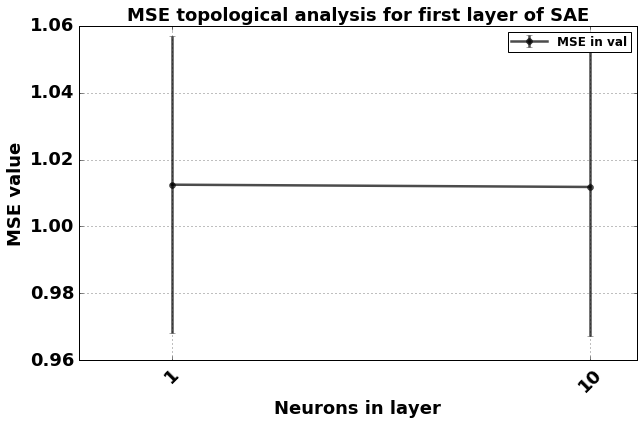

In [114]:
# Topological analysis
# SAE parameters extraction
%time

from sklearn import preprocessing

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
import keras.callbacks as callbacks

from keras.models import load_model

from Functions import PreProcessing as preproc


for log_id, log_entry in enumerate(log_entries):
    if log_entries[log_id]['package'] != 'StackedAutoEncoder':
        continue
    if log_entries[log_id]['date'] != choose_date:
        continue
    print 'StackedAutoEncoder analysis performed in %s and for %s analysis'%(
        log_entries[log_id]['date'],log_entries[log_id]['package'])
    
    # Read train info file
    train_info_name = '%s/train_info_files/%s_train_info.jbl'%(
        result_analysis_path,log_entries[log_id]['date'])
    
    [train_info] = joblib.load(train_info_name)
    
    # saving time
    if not train_info['topologic_anal_done']:
        continue
        
    top_info_name = result_analysis_path+'/output_files'+'/'+choose_date+'_top_sweep_losses.jbl'
    [losses]= joblib.load(top_info_name)
    
    import matplotlib.pyplot as plt
    %matplotlib inline  

    plt.rcParams['font.weight'] = 'bold'
    plt.rcParams['xtick.labelsize'] = 18
    plt.rcParams['ytick.labelsize'] = 18
    plt.rcParams['legend.numpoints'] = 1
    plt.rcParams['legend.handlelength'] = 3
    plt.rcParams['legend.borderpad'] = 0.3
    
    fig1 = plt.figure(figsize=(10,6))

    xtick = range(top_min, top_max+1, top_step)
    if top_min == 0:
        xtick[0] = 1
    plt.errorbar(xtick,
                  np.mean(losses,axis=0),
                  np.std(losses,axis=0),fmt='o-',
                  color='k',alpha=0.7,linewidth=2.5, label='MSE in val')
    plt.xticks(xtick,rotation=45)
    plt.xlim([top_min-1, top_max+1])
    plt.title('MSE topological analysis for first layer of SAE',fontsize=18, fontweight='bold')
    plt.xlabel('Neurons in layer',fontsize=18, fontweight='bold')
    plt.ylabel('MSE value',fontsize=18, fontweight='bold')

    plt.legend()
    plt.grid()
    

In [71]:
a = range(top_min, top_max+1, top_step)
a[0]=1
print a

[1, 10]
